This the first in a series of posts which constitute a "lit review" of sorts to document the range of methods scholars are using to compute the distribution of topics over time. 

Graphs of topic prevalence over time are some of the most ubiquitous in digital humanities discussions of topic modeling. They are used as a mechanism for identifying spikes in discourse and for depicting the relationship between the various discourses in a corpus. 

Topic prevalence over time is not, however, a measure that is returned with the standard modeling tools such as MALLET or Gensim. Instead, it is computed after the fact by combining the model data with external metadata and aggregating the model results. And, as it turns out, there are a number of ways that the data can be aggregated and displayed.

In this series of notebooks, I am looking at 4 different strategies for computing topic significance over time. These strategies are:

+ Average of topic weights per year
+ Smoothing or regression analysis
+ Proportion of total weights per year
+ Prevalence of the top topic per year

To identifying the different strategies that others have used to compute topic distribution, I have gone digging into the code released with various blog posts and topic model browsers. What I have recreated here is my current understanding of the strategies being deployed. I looked at the following sources for examples of ways others have computed topics over time:

+ Jonathan Goodwin's posts on topic modeling from 2012/2013:
    + [http://jgoodwin.net/blog/visualizing-topics-in-elh/](http://jgoodwin.net/blog/visualizing-topics-in-elh/)
    + [http://jgoodwin.net/blog/same-stuff-different-graph/](http://jgoodwin.net/blog/same-stuff-different-graph/)
    + [http://jgoodwin.net/blog/topics-in-theory/](http://jgoodwin.net/blog/topics-in-theory/) 
+ Ben Schmidt's posts on topic modeling from 2012/2013 and the post comments:
   + [http://sappingattention.blogspot.com/2013/01/keeping-words-in-topic-models.html](http://sappingattention.blogspot.com/2013/01/keeping-words-in-topic-models.html)
   + [http://sappingattention.blogspot.com/2012/11/when-you-have-mallet-everything-looks.html](http://sappingattention.blogspot.com/2012/11/when-you-have-mallet-everything-looks.html)
+ Andrew Goldstone's dfrtopics R package:
   + [https://github.com/agoldst/dfrtopics/blob/43362fd4aea25caedf59f610fb02f3aaa30334ca/R/matrices.R#L2-L122](https://github.com/agoldst/dfrtopics/blob/43362fd4aea25caedf59f610fb02f3aaa30334ca/R/matrices.R#L2-L122)
+ Andrew Goldstone's dfr-browser
    + [https://agoldst.github.io/dfr-browser/](https://agoldst.github.io/dfr-browser/)
+ Adrien Guille's TOM (TOpic Modeling) Python library:
   + [https://github.com/AdrienGuille/TOM/blob/master/tom_lib/nlp/topic_model.py#L171-L183](https://github.com/AdrienGuille/TOM/blob/master/tom_lib/nlp/topic_model.py#L171-L183) 
   + [https://github.com/AdrienGuille/TOM/blob/377ad642da99f3ab93b8af0140db0486e937eaab/build_topic_model_browser.py#L114-L126](https://github.com/AdrienGuille/TOM/blob/377ad642da99f3ab93b8af0140db0486e937eaab/build_topic_model_browser.py#L114-L126)
+ Amanda Regan and Joshua Catalano's topic model browser of Eleanor Roosevelt's *My Day*:
    + [https://github.com/regan008/ERMining/blob/master/prepdata/exploretopics.R#L17-L31](https://github.com/regan008/ERMining/blob/master/prepdata/exploretopics.R#L17-L31)
    + [https://regan008.shinyapps.io/mining_my_day/](https://regan008.shinyapps.io/mining_my_day/)
+ David Mimno's jsLDA viewer
    + [https://mimno.infosci.cornell.edu/jsLDA/jslda.html](https://mimno.infosci.cornell.edu/jsLDA/jslda.html)
    + [https://github.com/mimno/jsLDA/blob/71a6f021ba57c9b085163ccbc485e1124c383d0f/jslda.js#L426-L444](https://github.com/mimno/jsLDA/blob/71a6f021ba57c9b085163ccbc485e1124c383d0f/jslda.js#L426-L444)

I would love to hear if I have misunderstood the calculations taking place or about additional strategies or implementation ideas.

To explore a range of strategies for computing and visualizing topics over time from a standard LDA model, I am using a model I created from my dissertation materials. You can download the files needed to follow along from https://www.dropbox.com/s/9uf6kzkm1t12v6x/2017-06-21.zip?dl=0.

I created this model from periodicals produced by the Seventh-day Adventist denomination between 1859 and 1875 using Gensim. I split each periodical into individual pages, so that I can better capture the range of topics in each periodical issue and identify individual pages of interest. In the process of corpus creation, I filtered the tokens on each page, excluding both low frequency (words occurring in fewer than 20 documents) and high frequency (words occurring in more than 30% of all documents) words. In other words, don't read anything into the fact that "God" is missing from the model. I have modeled the most distinctive words for each page.

For historical context, during this period early Seventh-day Adventists formally organized as a denomination in 1863. They also launched their health reform efforts with the establishment of the Western Health Reform Institute (later renamed the Battle Creek Sanitarium) and started a health focused publication, *The Health Reformer*, both in 1866.

In [1]:
# Load the necessary libraries
import gensim # Note: I am running 1.0.1
from ggplot import *
import json
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd # Note: I am running 0.19.2
import pyLDAvis.gensim
import seaborn as sns
import warnings

In [2]:
# Enable in-notebook visualizations
%matplotlib inline
pyLDAvis.enable_notebook()

In [3]:
# Temporary fix for persistent warnings of an api change between pandas and seaborn.
warnings.filterwarnings('ignore')

In [4]:
pd.options.display.max_rows = 10

In [5]:
base_dir = "2017-06-21"
period = '1859-to-1875'
directory = "historical_periods"

In [6]:
lda_model = gensim.models.LdaModel.load(os.path.join(base_dir, 'models', directory, '{}.model'.format(period)))
corpus = gensim.corpora.MmCorpus(os.path.join(base_dir, 'corpora', directory, "{}.mm".format(period)))
dictionary = gensim.corpora.Dictionary.load(os.path.join(base_dir, 'corpora', directory, "{}.dict".format(period)))

# Visualize the model

To better understand the model that we are analyzing, we can first visualize the whole model using pyLDAvis. This provides us a picture of the overall topic weights and word distributions across all of the documents.

**Note**: the topic numbers here indicate in descending order the prevalence of the topic in the whole corpus. They are not the same as the topic ids used in the rest of this notebook.

In [7]:
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
0      9.768941        1       1 -0.146044 -0.118754
20     7.855201        1       2 -0.156423 -0.012198
1      7.686505        1       3 -0.043457 -0.105004
7      7.334614        1       4 -0.124762 -0.085137
18     6.973767        1       5  0.045624 -0.051633
...         ...      ...     ...       ...       ...
15     1.550978        1      21  0.199856 -0.037089
16     0.779892        1      22  0.239970  0.027886
8      0.767367        1      23 -0.064772  0.127108
24     0.443449        1      24  0.140812  0.207223
2      0.426417        1      25  0.073490  0.306933

[25 rows x 5 columns], topic_info=      Category         Freq        Term        Total  loglift  logprob
term                                                                  
324    Default  8751.000000  conference  8751.000000  30.0000  30.0000
125    Default  8966.000000     message  8966.000000  29.0000  29.0000
11173  Default  6597.000000        cent  6597.000000  28.0000  28.0000
6547   Default  6453.000000      wicked  6453.000000  27.0000  27.0000
2988   Default  8173.000000      report  8173.000000  26.0000  26.0000
...        ...          ...         ...          ...      ...      ...
990    Topic25   174.068538        corn   931.335245   3.7803  -4.9564
5957   Topic25   168.115925        bone   887.118948   3.7942  -4.9912
13581  Topic25   188.191540        tree  4570.945944   2.2675  -4.8784
592    Topic25   154.358959        food  6146.683143   1.7731  -5.0766
13257  Topic25   150.157670       beast  5265.277665   1.9003  -5.1042

[1981 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
13173     10  0.981920  abasement
11837      7  0.997376       abel
9226       1  0.025699    abolish
9226       3  0.945168    abolish
9226      12  0.011422    abolish
...      ...       ...        ...
734        1  0.067002       zion
734        4  0.279176       zion
734       13  0.001763       zion
734       15  0.651215       zion
14373      8  0.996311     zirkle

[11005 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 21, 2, 8, 19, 12, 22, 24, 18, 4, 7, 14, 10, 5, 15, 6, 11, 23, 13, 20, 16, 17, 9, 25, 3])

# Create the dataframes

While pyLDAvis gives us a good overall picture of the model data, we need to further manipulate the data in order to track change over time across the different publication years. 

I preprocessed the model and exported information about the weights per document and topic labels into CSV files for ease of compiling. I will release the code I used to export that information in a later notebook. 

In [8]:
metadata_filename = os.path.join(base_dir,'2017-05-corpus-stats/2017-05-Composite-OCR-statistics.csv')
index_filename = os.path.join(base_dir, 'corpora', directory, '{}.txt'.format(period))
labels_filename = os.path.join(base_dir, 'dataframes', directory, '{}_topicLabels.csv'.format(period))
doc_topic_filename = os.path.join(base_dir, 'dataframes', directory, '{}_dtm.csv'.format(period))

In [9]:
def doc_list(index_filename):
    """
    Read in from a json document with index position and filename. 
    File was created during the creation of the corpus (.mm) file to document
    the filename for each file as it was processed.
    
    Returns the index information as a dataframe.
    """
    with open(index_filename) as data_file:    
        data = json.load(data_file)
    docs = pd.DataFrame.from_dict(data, orient='index').reset_index()
    docs.columns = ['index_pos', 'doc_id']
    docs['index_pos'] = docs['index_pos'].astype(int)
  
    return docs


def compile_dataframe( index, dtm, labels, metadata):
    """
    Combines a series of dataframes to create a large composit dataframe.
    """
    doc2metadata = index.merge(metadata, on='doc_id', how="left")
    topics_expanded = dtm.merge(labels, on='topic_id')
    
    df = topics_expanded.merge(doc2metadata, on="index_pos", how="left")
    
    return df

In [10]:
metadata = pd.read_csv(metadata_filename, usecols=['doc_id', 'year','title'])
docs_index = doc_list(index_filename)
dt = pd.read_csv(doc_topic_filename)
labels = pd.read_csv(labels_filename)

The first step, following [Andrew Goldstone's process in his topic model browser](https://github.com/agoldst/dfrtopics/blob/43362fd4aea25caedf59f610fb02f3aaa30334ca/R/matrices.R#L373-L415), is to normalize the weights for each document, so that they total to "1".

As a note, Goldstone first smooths the weights by adding the alpha hyperparameter to each of the weights, which I am not doing here.

In [11]:
# Reorient from long to wide
dtm = dt.pivot(index='index_pos', columns='topic_id', values='topic_weight').fillna(0)

# Divide each value in a row by the sum of the row to normalize the values
dtm = (dtm.T/dtm.sum(axis=1)).T

# Shift back to a long dataframe
dt_norm = dtm.stack().reset_index()
dt_norm.columns = ['index_pos', 'topic_id', 'norm_topic_weight']

With the document/topic dataframe normalized, we can compile our full dataframe.

In [12]:
df = compile_dataframe(docs_index, dt_norm, labels, metadata)

In [13]:
df

,index_pos,topic_id,norm_topic_weight,topic_words,doc_id,year,title
0,0,0,0.045525,"satan, salvation, sinner, righteousness, peace...",GCB186305XX-VXX-XX-page1.txt,1863,GCB
1,1,0,0.000000,"satan, salvation, sinner, righteousness, peace...",GCB186305XX-VXX-XX-page2.txt,1863,GCB
2,2,0,0.000000,"satan, salvation, sinner, righteousness, peace...",GCB186305XX-VXX-XX-page3.txt,1863,GCB
3,3,0,0.000000,"satan, salvation, sinner, righteousness, peace...",GCB186305XX-VXX-XX-page4.txt,1863,GCB
4,4,0,0.000000,"satan, salvation, sinner, righteousness, peace...",GCB186305XX-VXX-XX-page5.txt,1863,GCB
...,...,...,...,...,...,...,...
288595,11539,24,0.000000,"jerusalem, thess, parable, lazarus, thou_hast,...",YI18721201-V20-12-page4.txt,1872,YI
288596,11540,24,0.000000,"jerusalem, thess, parable, lazarus, thou_hast,...",YI18721201-V20-12-page5.txt,1872,YI
288597,11541,24,0.000000,"jerusalem, thess, parable, lazarus, thou_hast,...",YI18721201-V20-12-page6.txt,1872,YI
288598,11542,24,0.012192,"jerusalem, thess, parable, lazarus, thou_hast,...",YI18721201-V20-12-page7.txt,1872,YI


# Data dictionary:

+ `index_pos` : Gensim uses the order in which the docs were streamed to link back the data and the source file. `index_pos` refers to the index id for the individual doc, which I used to link the resulting model information with the document name.
+ `topic_id` : The numerical id for each topic. For this model, I used 20 topics to classify the periodical pages.
+ `norm_topic_weight` : The proportion of the tokens in the document that are part of the topic, normalized per doc.
+ `topic_words` : The top 6 words in the topic.
+ `doc_id` : The file name of the document. The filename contains metadata information about the document, such as the periodical title, date of publication, volume, issue, and page number.
+ `year` : Year the document was published (according to the filename)
+ `title` : Periodical that the page was published in.

# Summary Statistics

We can get an overall view of our data by computing some basic statistics.

In [14]:
# Dropping the zero values so that we see the larger patterns in the data
df_sum = df[df['norm_topic_weight'] != 0]

In [15]:
print("Max: {}".format(df_sum['norm_topic_weight'].max()))
print("Min: {}".format(df_sum['norm_topic_weight'].min()))
print("Average: {}".format(df_sum['norm_topic_weight'].mean()))
print("Median: {}".format(df_sum['norm_topic_weight'].median()))
print("Most frequent value: {}".format(df_sum['norm_topic_weight'].round(3).value_counts().idxmax()))

Max: 1.0
Min: 0.010027314043872615
Average: 0.09222067775487706
Median: 0.05201414311615885
Most frequent value: 0.011


The topics range from 100% of the tokens in a document to 1% (excluding the zero values), with an average at 9% and a median value of 5%. The most frequent value is near 1%, which indicates that the data predominantly describes topics that have a minor presence in the documents.

One way to visualize the overall structure of the data is to look at all of the topic weights for each topic id using a scatterplot.

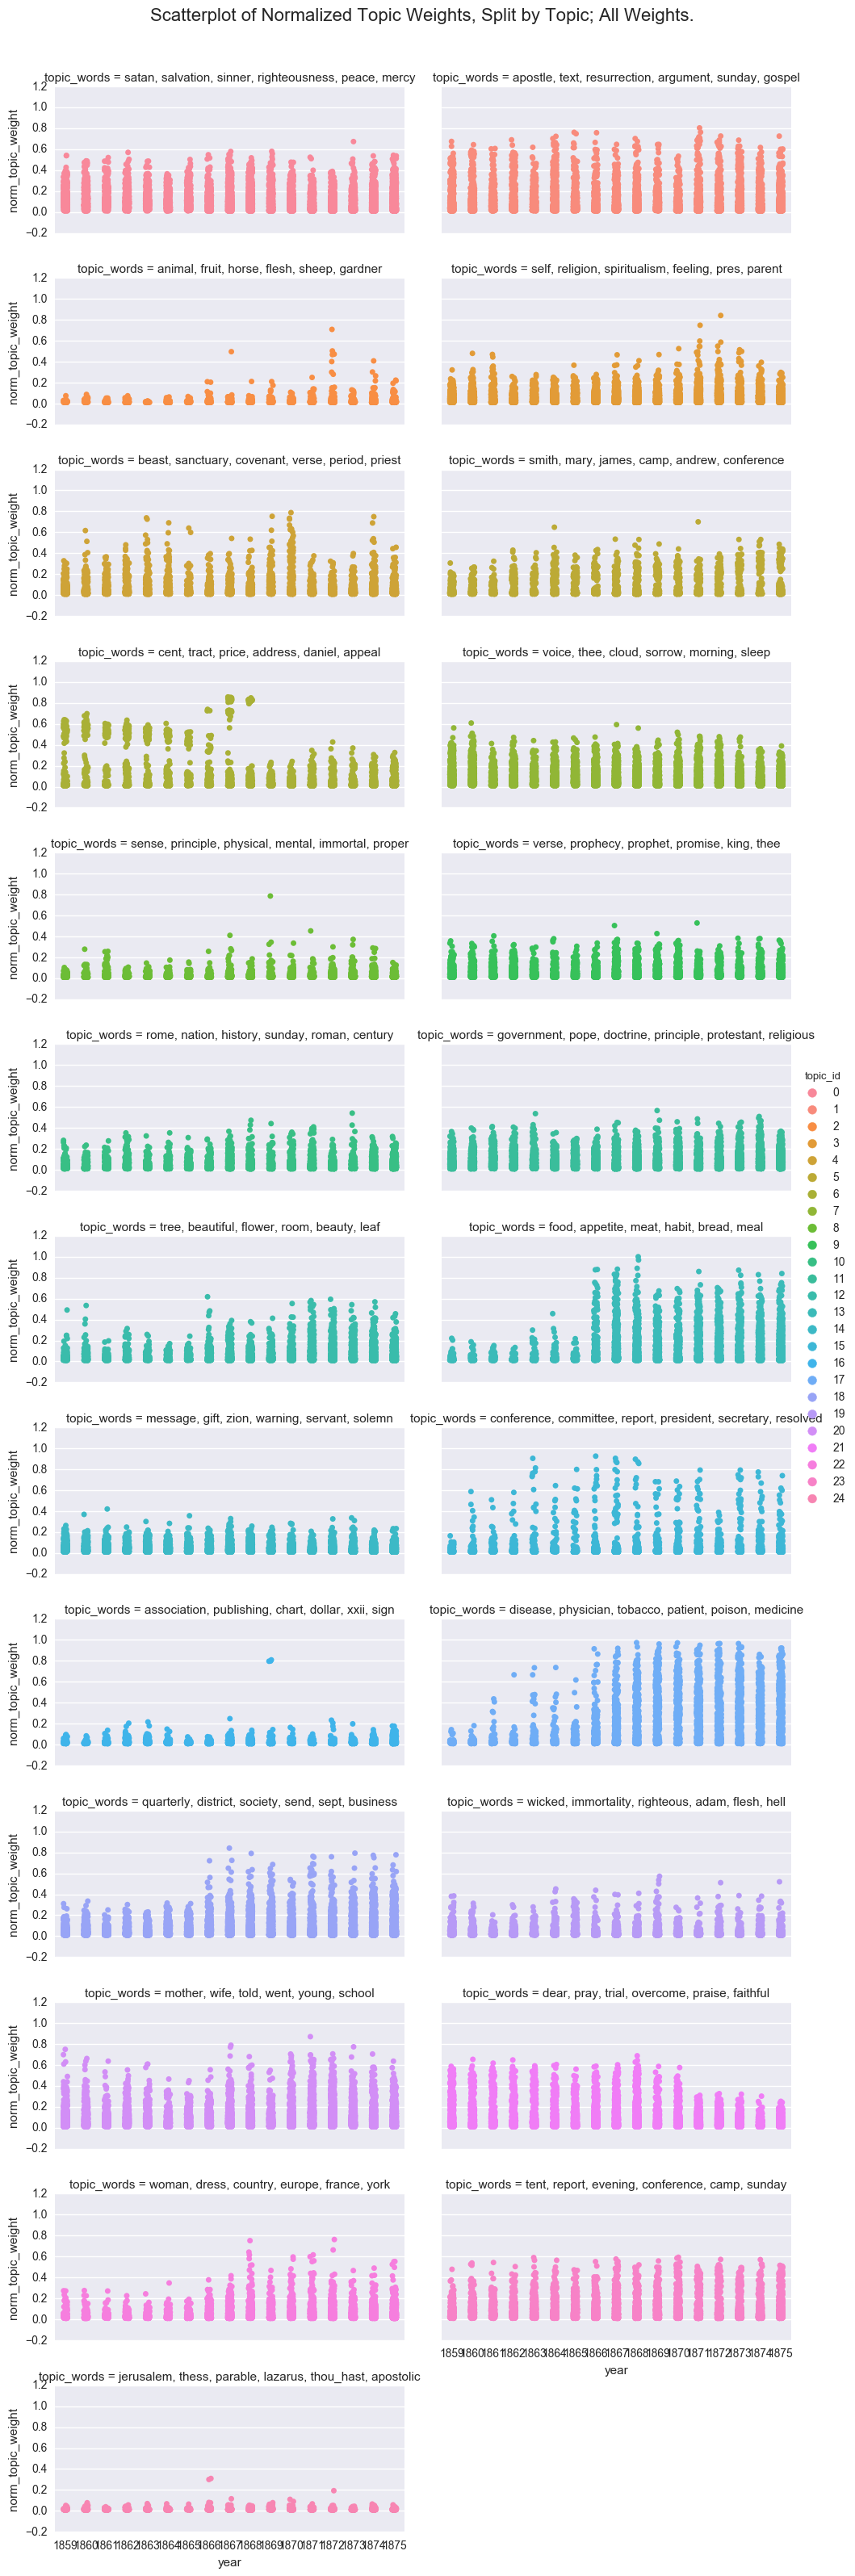

In [16]:
p = sns.factorplot(x="year", y='norm_topic_weight', hue="topic_id", col='topic_words', col_wrap=2, 
                   kind='strip', size=2.5, aspect=2, jitter=1, data=df_sum)
p.fig.subplots_adjust(top=0.95)
p.fig.suptitle("Scatterplot of Normalized Topic Weights, Split by Topic; All Weights.", fontsize=16)

While fun, this is too many plots to be useful, so I will move forward with a subset of the topics. However, if you decide to experiment with the notebook, you can switch back to the full dataframe.

In [17]:
dfs = df[(df['topic_id'] >= 15) & (df['topic_id'] <=20)]

# Average of topic weights per year

The first strategy I found for aggregating topic weights is to average the topic weights per year. 

The average topic weight is computed by adding all of the weights for a given topic in a time period and dividing by the total number of documents in that time period. This gives us the average weight of the topic over all documents in the corpus. 

One complication I encountered while work through this is while MALLET reports a weight (be it ever so small) for each topic for all the documents, Gensim by default drops topic information for a document if the weight is under 0.01. This presents a wrinkle for computing averages from Gensim-produced data, as the data needs be expanded before we can compute the average weight of a topic over the corpus (rather than the average over its significant appearances). To do that, I added a 0 value for the missing topic values during the normalizing steps above.

We can use the aggregation functions in Seaborn, a Python graphing library, to get a quick overview of the average topic weight by year. By default, the pointplot and bar plot functions use the mean to compute the "[central tendency and confidence interval](http://seaborn.pydata.org/tutorial/categorical.html)" of categorical data. For more control of the calculation, we can also compute the averages externally.

In [18]:
order = ['conference, committee, report, president, secretary, resolved',
         'association, publishing, chart, dollar, xxii, sign',
         'disease, physician, tobacco, patient, poison, medicine',
         'quarterly, district, society, send, sept, business',
         'wicked, immortality, righteous, adam, flesh, hell',
         'mother, wife, told, went, young, school' 
        ]

In [19]:
def create_pointplot(df, y_value, hue=None, order=order, col=None, wrap=None, size=5, aspect=1.5, title=""):
    p = sns.factorplot(x="year", y=y_value, kind='point', hue_order=order, hue=hue, 
                       col=col, col_wrap=wrap, col_order=order, size=size, aspect=aspect, data=df)
    p.fig.subplots_adjust(top=0.9)
    p.fig.suptitle(title, fontsize=16)
    return p

In [20]:
def create_bar(df, y_value, hue=None, order=order, col=None, wrap=None, size=5, aspect=1.5, title=""):
    p = sns.factorplot(x="year", y=y_value, kind='bar', hue_order=order, hue=hue, 
                       col=col, col_wrap=wrap, col_order=order, size=size, aspect=aspect, data=df)
    p.fig.subplots_adjust(top=0.9)
    p.fig.suptitle(title, fontsize=16)
    return p

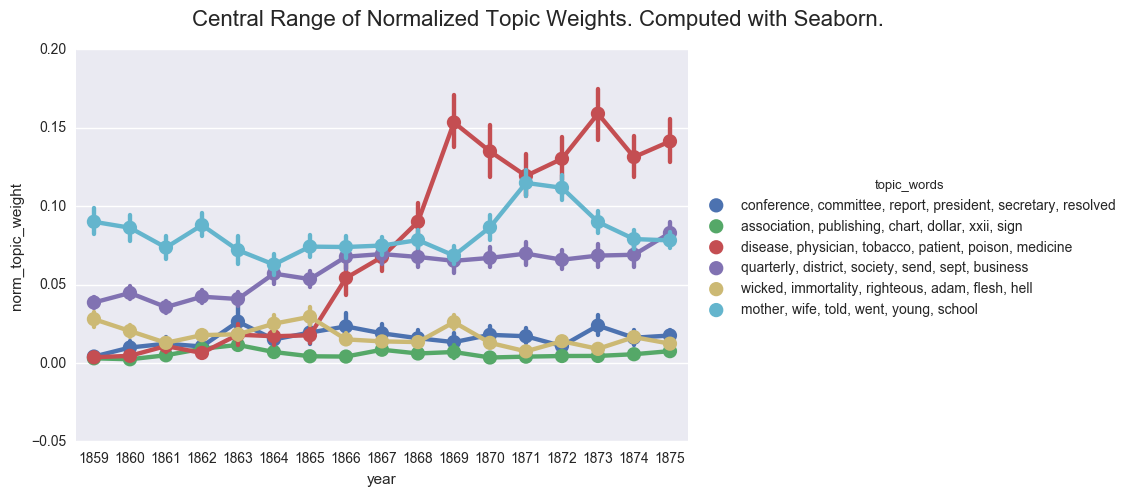

In [21]:
create_pointplot(dfs, 'norm_topic_weight', hue='topic_words', order=order, size=5, aspect=1.5,
                 title="Central Range of Normalized Topic Weights. Computed with Seaborn.")

One of the common visualizations is to show each plot separately through a facet grid. While this helps us to isolate the contours of each individual topic, it is harder to track the relationship between the topics. 

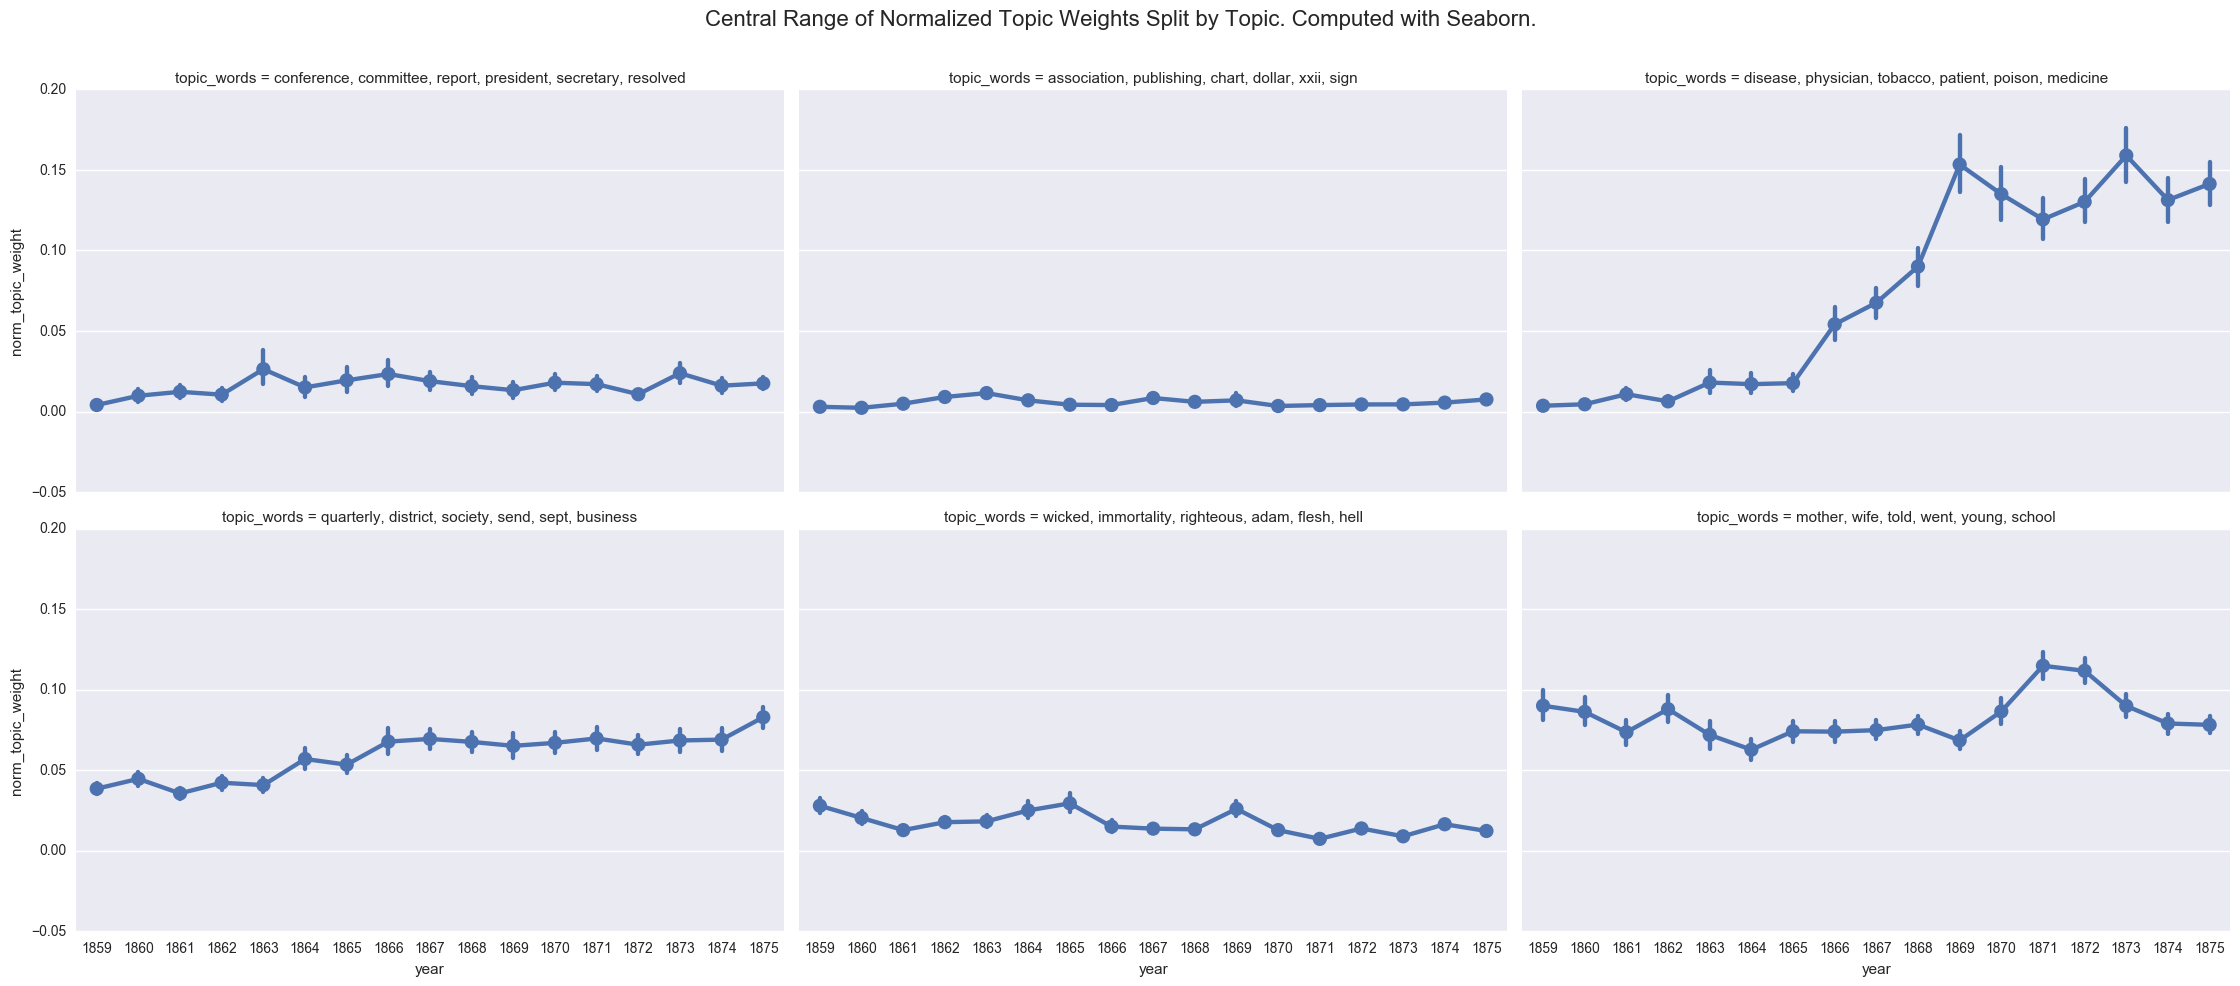

In [22]:
create_pointplot(dfs, 'norm_topic_weight', col='topic_words', wrap=3, 
                 title="Central Range of Normalized Topic Weights Split by Topic. Computed with Seaborn.")

We can also compute the average weight manually.

In [23]:
# Group by year and topic id
df_avg = df.groupby(['year', 'topic_id']).agg({'norm_topic_weight': 'sum'})

# Compute the mean per year
df_avg = df_avg.groupby(level=0).apply(lambda x: x/x.sum()).reset_index()
df_avg.columns = ['year', 'topic_id', 'average_weight']

# Merge the dataframes
df_avg = df_avg.merge(labels, on='topic_id')

# Retrieve sample
dfs_avg = df_avg[(df_avg['topic_id'] >=15 ) & (df_avg['topic_id']<= 20)]

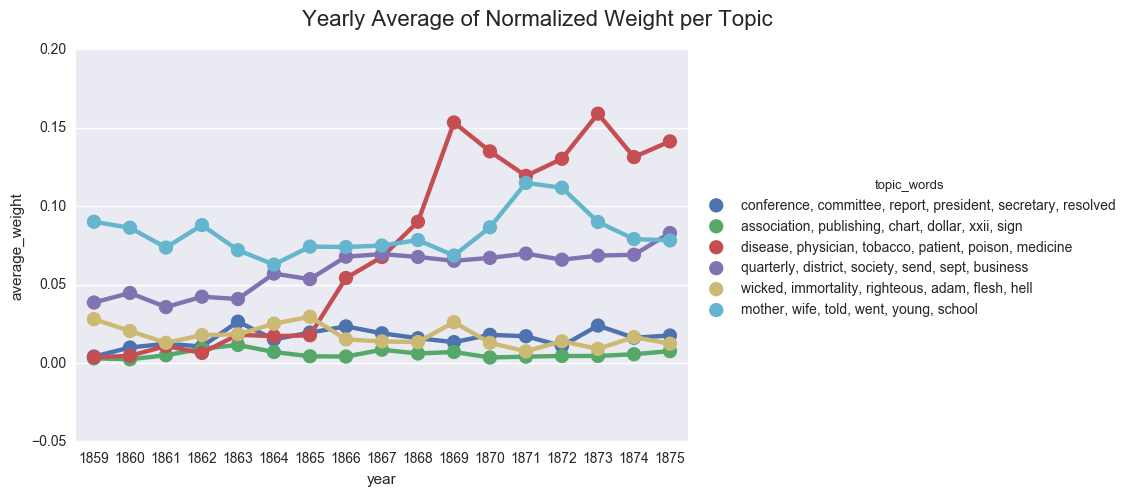

In [24]:
create_pointplot(dfs_avg, 'average_weight', hue="topic_words",
                title="Yearly Average of Normalized Weight per Topic")

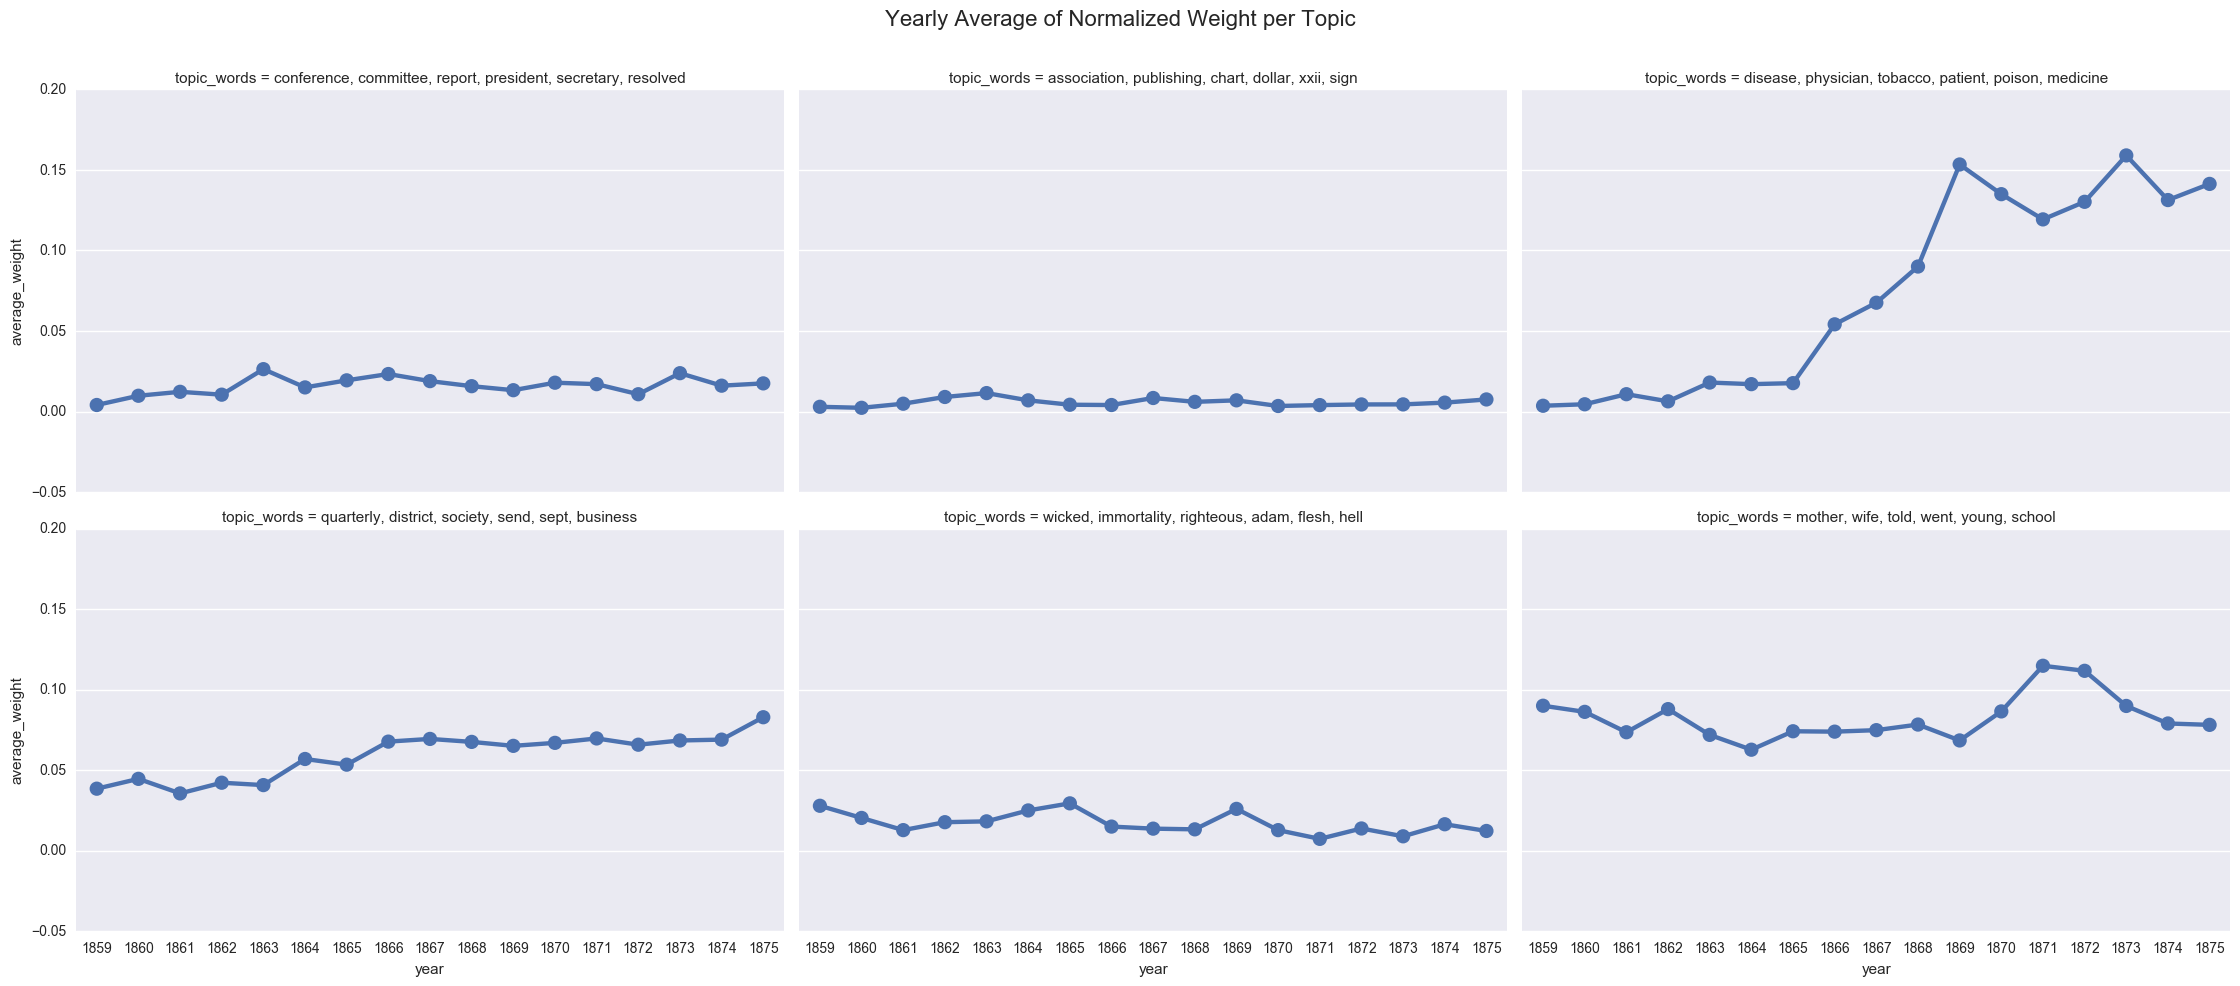

In [25]:
create_pointplot(dfs_avg, 'average_weight', col="topic_words", wrap=3,
                title="Yearly Average of Normalized Weight per Topic")

We can also display the averages as a bar chart, which encourages us to think about each year as discrete.

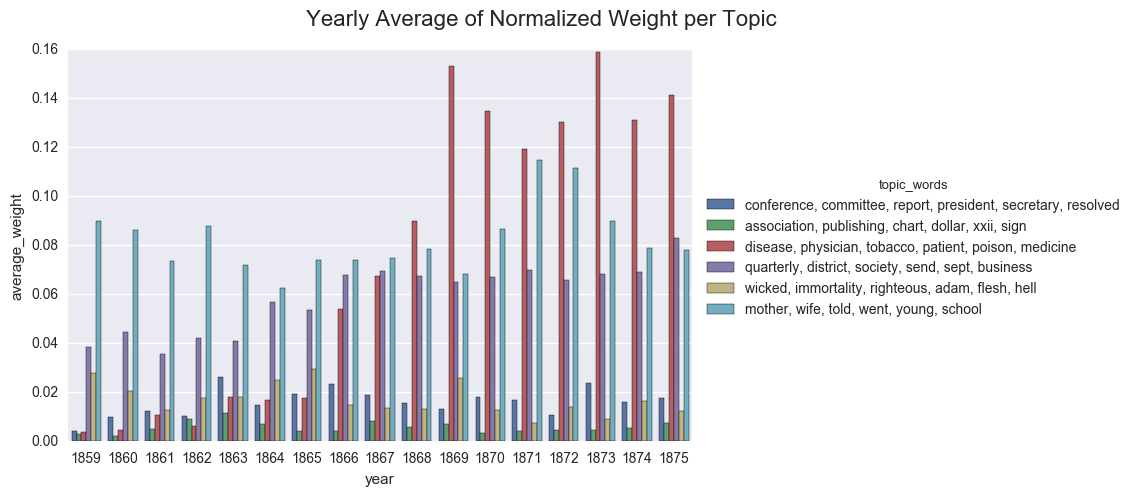

In [26]:
create_bar(dfs_avg, 'average_weight', order=order, hue="topic_words",
          title="Yearly Average of Normalized Weight per Topic")

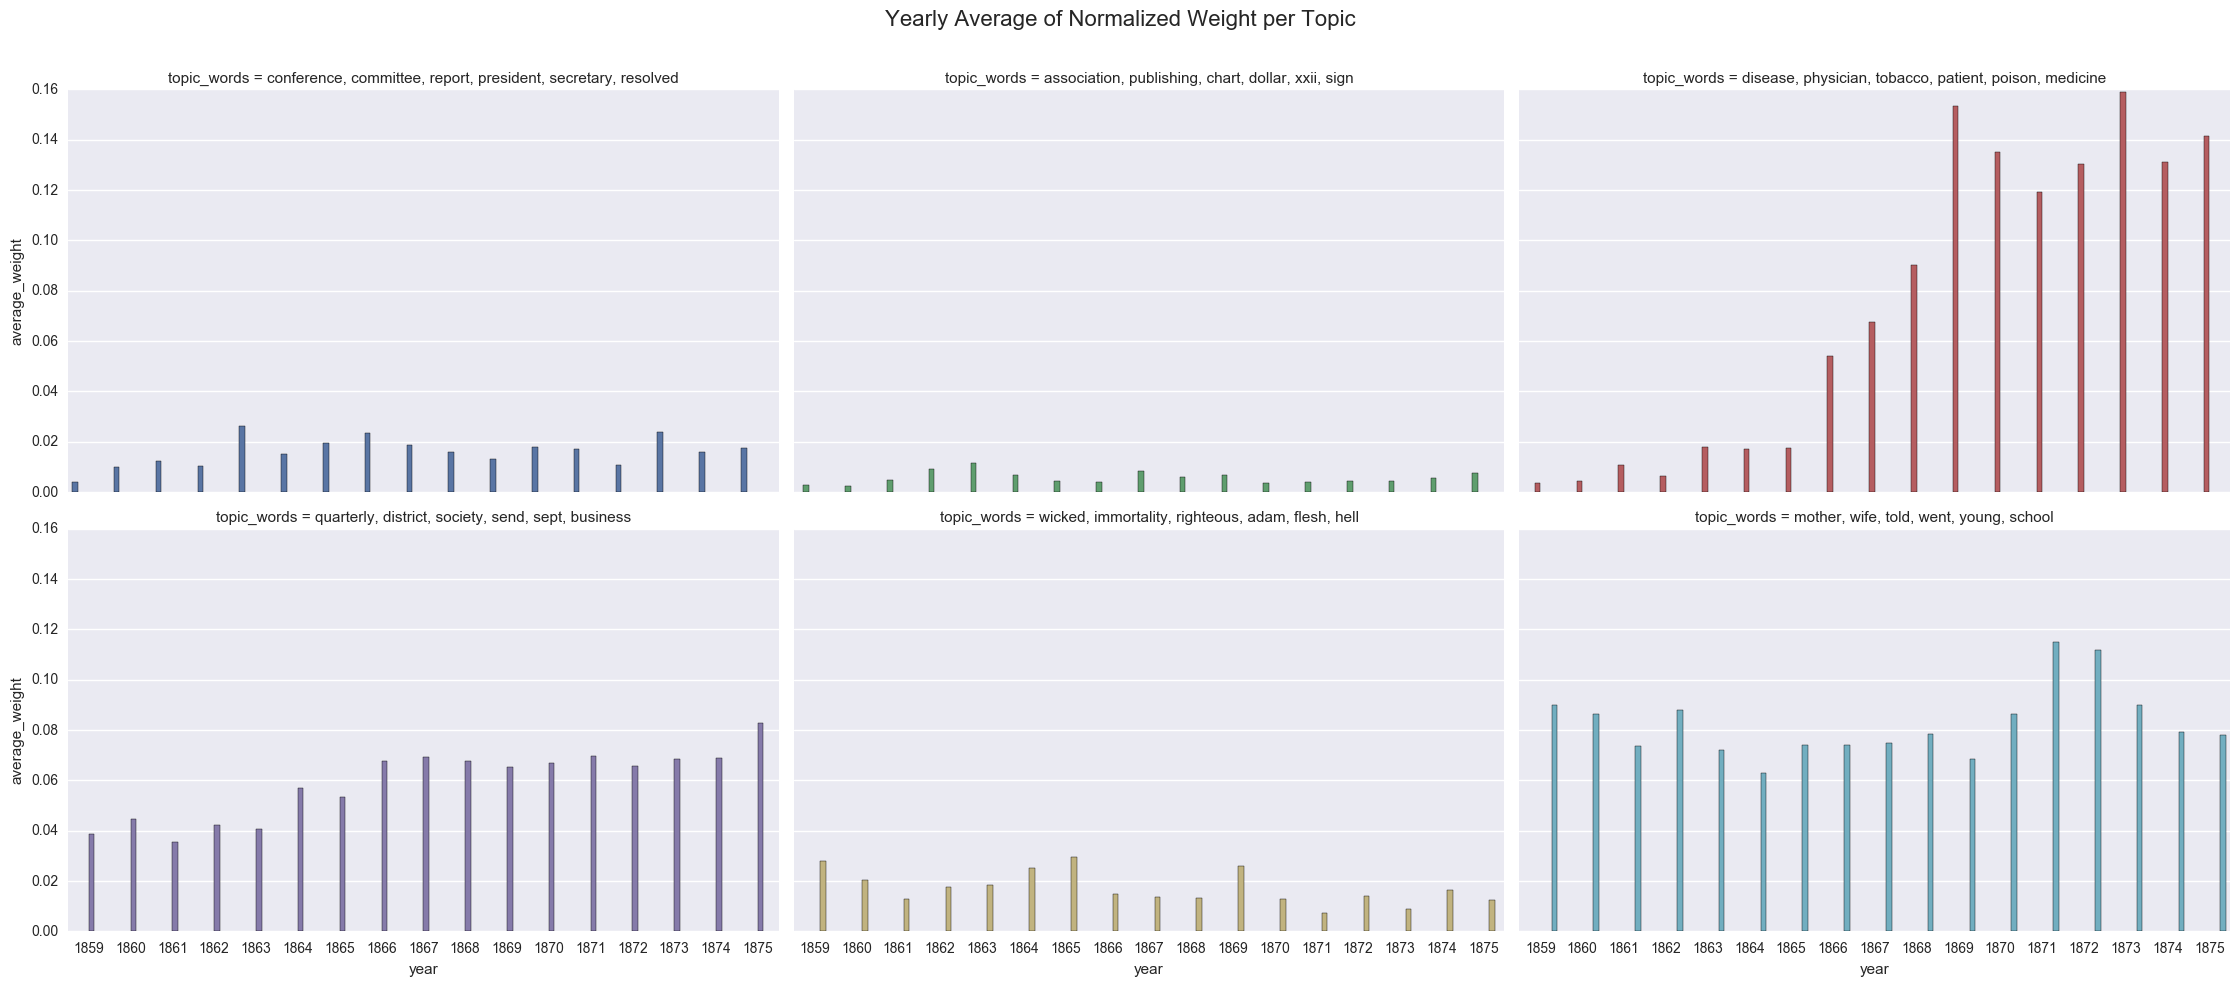

In [27]:
create_bar(dfs_avg, 'average_weight', order=order, hue="topic_words", col='topic_words',wrap=3,
          title="Yearly Average of Normalized Weight per Topic")

As a sanity check, we can show the importance of the 0 values by excluding those lines from the dataframe and using Seaborn to compute the average topic weight per year.

In [28]:
df_filtered = dfs[dfs['norm_topic_weight'] > 0]

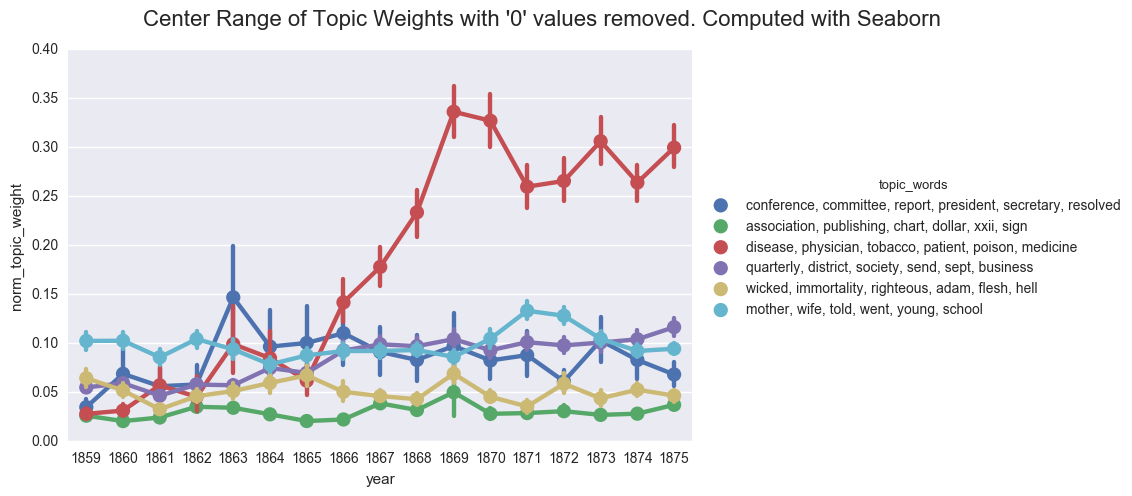

In [29]:
create_pointplot(df_filtered, 'norm_topic_weight', hue='topic_words',
                title="Center Range of Topic Weights with '0' values removed. Computed with Seaborn")

If we were to rely on this graph, we would likely postulate that the discourse of the denomination became overwhelmingly inflected with discussions of health starting in 1868. And we would likely fail to appreciate the ways that business and domestic concerns followed similar contours and were nearly as prevalent in the overall literature of the time.

Next I will look at using smoothing functions for charting topic changes over time.